In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import pandas as pd
import numpy as np

# Define the number of transactions for the DataFrame
num_transactions = 1000

# 1. Generate transaction_date between "2025-01-01" to "2025-12-31"
start_date = pd.to_datetime("2025-01-01")
end_date = pd.to_datetime("2025-12-31")

# Create a range of possible dates (e.g., hourly) and sample from it
# This ensures dates are within the specified range and can be random
all_possible_dates = pd.date_range(start=start_date, end=end_date, freq='D')
transaction_dates = np.random.choice(all_possible_dates, size=num_transactions, replace=True)

# 2. Generate customer_id with varying repetition
customer_id_pool = []

#   a. Frequent customers: A few IDs that will appear many times
frequent_base_ids = [f'C_{i:03d}' for i in range(1, 6)] # C_001 to C_005
for cid in frequent_base_ids:
    customer_id_pool.extend([cid] * 200) # Each frequent customer ID added 200 times to the pool

#   b. Less frequent customers: A few IDs that will appear a moderate number of times
less_frequent_base_ids = [f'C_{i:03d}' for i in range(6, 16)] # C_006 to C_015
for cid in less_frequent_base_ids:
    customer_id_pool.extend([cid] * 50) # Each less frequent customer ID added 50 times to the pool

#   c. No repeat/rare customers: A larger set of IDs that will appear only once or twice
rare_base_ids = [f'C_{i:03d}' for i in range(16, 100)] # C_016 to C_099
for cid in rare_base_ids:
    customer_id_pool.extend([cid] * np.random.randint(1, 3)) # Each rare customer ID added 1 or 2 times

# Sample customer IDs from the created pool with replacement
# This allows the desired frequency distribution to emerge
customer_ids = np.random.choice(customer_id_pool, size=num_transactions, replace=True)

# 3. Generate total_amt (random float values)
total_amts = np.random.uniform(10.0, 1000.0, size=num_transactions)

# Create the DataFrame
df = pd.DataFrame({
    'customer_id': customer_ids,
    'transaction_date': transaction_dates,
    'total_amt': total_amts
})

# Optional: Sort the DataFrame by transaction_date
df = df.sort_values(by='transaction_date').reset_index(drop=True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Display the first few rows and information about the DataFrame
print("\nDataFrame Info:\n")
df.info()


DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       1000 non-null   object        
 1   transaction_date  1000 non-null   datetime64[ns]
 2   total_amt         1000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.6+ KB


## Quickly Experimenting with the `lineregress` method

In [ ]:
# Sample data
a = [1,2,3,4,5,6,7,8,9,10]
y = [12,23,24,26,28,30,34,45,43,44]

In [ ]:
# Lineregress from Scipy and what it returns
stats.linregress(a,y)

LinregressResult(slope=np.float64(3.387878787878788), intercept=np.float64(12.266666666666662), rvalue=np.float64(0.9602642507715704), pvalue=np.float64(1.0395445391848758e-05), stderr=np.float64(0.34812893550983376), intercept_stderr=np.float64(2.1600832382016173))

In [ ]:
# Quick Function to plot the regression
def plot_regression(x,y):
  plt.scatter(x,y, color = 'gray')
  plt.plot(x,
          stats.linregress(x,y).slope*np.array(x) + stats.linregress(x,y).intercept,
          color = 'red',
          linestyle='--')
  plt.suptitle("Slope of the Linear Regression [Expenses x Time]")
  plt.title(f"Slope: {np.degrees(np.arctan(stats.linregress(x,y).slope)):.0f} degrees. Positive = Buying more | Negative = Buying less", size=9, color='gray')
  plt.show()

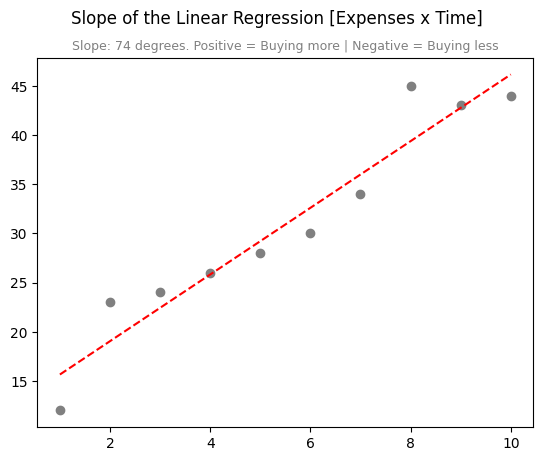

In [ ]:
# Plot
plot_regression(a,y)

## Calculating the Degrees Line for one customer

Our logic is:
1. Filter customer's transactions
2. Group it by month
3. Each month is an index within a time frame. So, we are not stuck with 12 months, but we can check the regression lines for 15, 18 or N months, for example.
4. Normalize both X and Y to be on the same scale and don't distort the slope.
5. Calculate the slope of the linear regression
6. Transform it to degrees.

In [ ]:
# look at the data
df.sample(3)

,customer_id,transaction_date,total_amt,mth
500,C_002,2025-07-13,357.418951,7
809,C_003,2025-10-28,263.265080,10
428,C_005,2025-06-12,992.300647,6


In [ ]:
# Create new column month
df['mth'] = df['transaction_date'].dt.month

# Group customers by month
df_group = (
    df
    .groupby(['mth','customer_id'])
    ['total_amt']
    .sum()
    .reset_index()
)

# View
df_group.sample(3)

,mth,customer_id,total_amt
99,5,C_030,340.805136
69,4,C_007,1929.261188
114,6,C_009,1713.760507


In [ ]:
# Check how many customers are not buying every month
(df_group.groupby('customer_id').mth.nunique()<12).sum()

np.int64(55)

For the customers who doesn't have purchased anything in the 12 months, we need to add 0 for the months without transactions

In [ ]:
# Standardize the data
def min_max_standardize(vals):
    return (vals - np.min(vals)) / (np.max(vals) - np.min(vals))


def get_trend_degrees(customer):

  # Filter the data
  one_customer = df.query('customer_id == @customer')
  one_customer = one_customer.groupby('mth').total_amt.sum().reset_index().rename(columns={'mth':'period_idx'})

  # Check if all months are in the data
  cnt = one_customer.groupby('period_idx').period_idx.nunique().sum()

  # If not, add 0 to the months without transactions
  if cnt < 12:
      # Create a DataFrame with all 12 months
      all_months = pd.DataFrame({'period_idx': range(1, 13), 'total_amt': 0})

      # Merge with the existing one_customer data.
      # Use 'right' merge to keep all 12 months from 'all_months' and fill missing total_amt.
      one_customer = pd.merge(all_months, one_customer, on='period_idx', how='left', suffixes=('_all', ''))

      # Combine the total_amt columns, preferring the actual data over the 0 from all_months
      one_customer['total_amt'] = one_customer['total_amt'].fillna(one_customer['total_amt_all'])

      # Drop the temporary _all column if it exists
      one_customer = one_customer.drop(columns=['total_amt_all'])

      # Sort by period_idx to ensure correct order
      one_customer = one_customer.sort_values(by='period_idx').reset_index(drop=True)

  # Min Max Standardization
  X = min_max_standardize(one_customer['period_idx'])
  y = min_max_standardize(one_customer['total_amt'])

  # Plot
  plot_regression(X,y)

  # Calculate slope
  slope = stats.linregress(X,y)[0]

  # Calculate angle degrees
  angle = np.arctan(slope)
  angle = np.degrees(angle)

  return angle


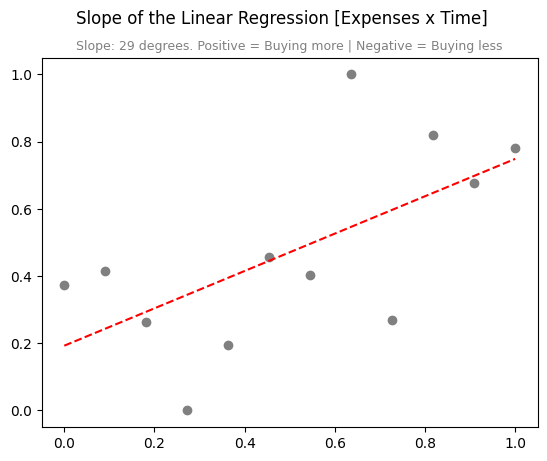

np.float64(29.072734754733546)

In [ ]:
# Example of strong customer
get_trend_degrees('C_008')

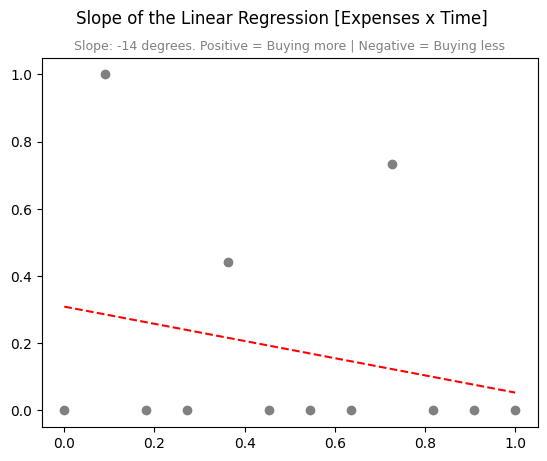

np.float64(-14.349786961979431)

In [ ]:
# Example of customer stop buying
get_trend_degrees('C_030')